In [1]:
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Choose GPU if available, otherwise fallback to CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

cuda


# Parameters

In [3]:
# Set variances for initial states
variance2 = 10
variance1 = 1 / variance2 # Inverse variance

N = 10  # Number of modes

# Initializations

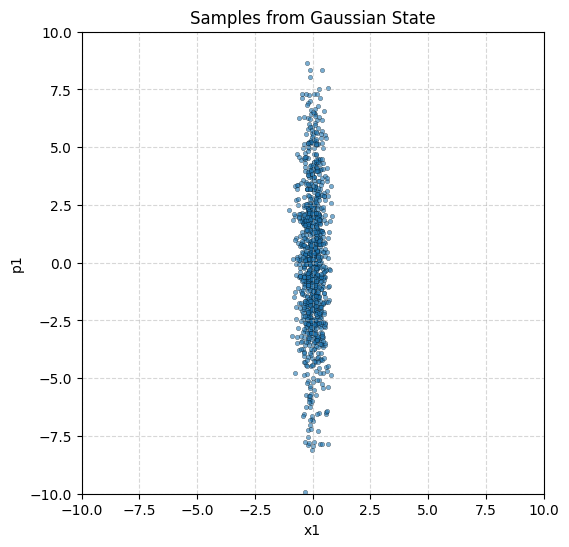

In [4]:
# Helper function to draw 2D scatter plots of sampled Gaussian distributions
def draw_scatter(samples1, samples2, label1, label2):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples1, samples2, s=10, alpha=0.6, edgecolors='k', linewidths=0.3)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title('Samples from Gaussian State')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal')  # Make x and y axis scales equal
    plt.show()

# Function to check if a matrix is positive semidefinite
def check_psd(matrix, tol=1e-8):
    if not np.allclose(matrix, matrix.T, atol=tol):
        raise ValueError("Matrix is not symmetric.")  # PSD requires symmetry
    eigenvalues = np.linalg.eigvalsh(matrix)  # Eigenvalues for symmetric matrix
    min_eig = np.min(eigenvalues)
    is_psd = min_eig >= -tol  # Allow small numerical errors
    violation = 0 if is_psd else abs(min_eig)
    return is_psd, violation
# Initialize diagonal covariance matrix with alternating variances
initial_covariance = torch.zeros((2*N,2*N)).to(DEVICE)
for i in range(0,2*N,4): 
    initial_covariance[i][i] = variance1
    initial_covariance[i+1][i+1] = variance2
    initial_covariance[i+2][i+2] = variance2
    initial_covariance[i+3][i+3] = variance1

# Extract 2x2 submatrix for x1, p1
x_indices = [0, 1]
sigma_out = initial_covariance[np.ix_(x_indices, x_indices)].cpu()
mean_x = np.zeros(2)  # Zero mean
samples = np.random.multivariate_normal(mean_x, sigma_out, size=1000)  # Sample points
draw_scatter(samples.T[0], samples.T[1], 'x1', 'p1')  # Visualize

# Final covariance

In [5]:
# Define phase shift transformation matrix for a specific mode
def phase_shift90(mode, phi=np.pi/2):
    S = torch.eye(2*N, device=DEVICE)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    idx = 2 * mode
    S[idx, idx] = cos_phi
    S[idx, idx+1] = sin_phi
    S[idx+1, idx] = -sin_phi
    S[idx+1, idx+1] = cos_phi
    return S

# Define beamsplitter transformation between two modes
def beam_splitter(mode1, mode2, theta=np.pi/4):
    S = torch.eye(2 * N, device=DEVICE)
    c = np.cos(theta)
    s = np.sin(theta)
    i = 2 * mode1
    j = 2 * mode2
    indices = [i, i+1, j, j+1]
    # BS_block = torch.tensor([
    #     [c, 0,  s, 0],
    #     [0, c,  0, s],
    #     [-s, 0, c, 0],
    #     [0, -s, 0, c]
    # ], dtype=S.dtype, device=DEVICE)
    BS_block = torch.tensor([
        [c, 0, -s, 0],
        [0, c,  0,-s],
        [s, 0,  c, 0],
        [0, s,  0, c]
    ], dtype=S.dtype, device=DEVICE)
    S[np.ix_(indices, indices)] = BS_block
    return S

In [8]:
# Build full transformation matrix S by chaining phase shifts and beamsplitters

# FIRST beam-splitter
S = beam_splitter(0,1)
for i in tqdm(range(2,N-1,2)):
    S = beam_splitter(i, i+1) @ S

# Second beam-splitter
for i in tqdm(range(1,N-1,2)):
    S = beam_splitter(i+1, i) @ S

# for i in tqdm(range(2, N-1,2)):  # Iterate over all remaining modes
#     S = beam_splitter(i, i-1,theta=np.pi/4) @ S
# Apply transformation to the initial covariance matrix
final_covariance = (S @ initial_covariance @ (S.T)).cpu()

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1344.54it/s]


In [9]:
final_covariance

tensor([[ 5.0500e+00,  0.0000e+00, -3.5002e+00,  0.0000e+00,  3.5002e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  5.0500e+00,  0.0000e+00,  3.5002e+00,  0.0000e+00,
         -3.5002e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-3.5002e+00,  0.0000e+00,  5.0500e+00,  0.0000e+00,  8.9407e-08,
          0.0000e+00, -2.4750e+00,  0.0000e+00,  2.4750e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  3.5002e+00,  0.0000e+00,  5.0500e+00,  0.0000e+00,
         -8.9407e-09,  0.0000e+00, 

#  Analysis

In [7]:
def display_covariance(tensor: torch.Tensor, zero_tol=1e-3):
    import pandas as pd
    import numpy as np
    
    arr = tensor.cpu().numpy()
    arr_rounded = np.round(arr, 3)

    rows_nonzero = np.where(np.any(np.abs(arr_rounded) >= zero_tol, axis=1))[0]
    cols_nonzero = np.where(np.any(np.abs(arr_rounded) >= zero_tol, axis=0))[0]

    submatrix = arr_rounded[np.ix_(rows_nonzero, cols_nonzero)]
    submatrix_str = np.where(np.abs(submatrix) < zero_tol, '', submatrix.astype(str))

    def create_labels(indices):
        labels = []
        for i in indices:
            mode = (i // 2) + 1
            quad = 'x' if i % 2 == 0 else 'p'
            labels.append(f"{quad}{mode}")
        return labels

    row_labels = create_labels(rows_nonzero)
    col_labels = create_labels(cols_nonzero)

    df = pd.DataFrame(submatrix_str, index=row_labels, columns=col_labels)
    
    # Set pandas display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    
    # Use pandas styling to add borders
    styled_df = df.style.set_table_styles([
        {'selector': 'th, td', 
         'props': [('border', '1px solid black'),
                   ('padding', '4px'), 
                   ('text-align', 'center')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse')]}
    ])
    
    display(styled_df)


In [8]:
display_covariance(final_covariance)

,x1,p1,x2,p2,x3,p3,x4,p4,x5,p5,x6,p6,x7,p7,x8,p8,x9,p9,x10,p10
x1,5.05,,-3.5,,3.5,,,,,,,,,,,,,,,
p1,,5.05,,3.5,,-3.5,,,,,,,,,,,,,,
x2,-3.5,,5.05,,,,-2.475,,2.475,,,,,,,,,,,
p2,,3.5,,5.05,,,,2.475,,-2.475,,,,,,,,,,
x3,3.5,,,,5.05,,-2.475,,2.475,,,,,,,,,,,
p3,,-3.5,,,,5.05,,2.475,,-2.475,,,,,,,,,,
x4,,,-2.475,,-2.475,,5.05,,,,-2.475,,2.475,,,,,,,
p4,,,,2.475,,2.475,,5.05,,,,2.475,,-2.475,,,,,,
x5,,,2.475,,2.475,,,,5.05,,-2.475,,2.475,,,,,,,
p5,,,,-2.475,,-2.475,,,,5.05,,2.475,,-2.475,,,,,,


In [9]:
display_covariance(initial_covariance)

,x1,p1,x2,p2,x3,p3,x4,p4,x5,p5,x6,p6,x7,p7,x8,p8,x9,p9,x10,p10
x1,0.1,,,,,,,,,,,,,,,,,,,
p1,,10.0,,,,,,,,,,,,,,,,,,
x2,,,10.0,,,,,,,,,,,,,,,,,
p2,,,,0.1,,,,,,,,,,,,,,,,
x3,,,,,0.1,,,,,,,,,,,,,,,
p3,,,,,,10.0,,,,,,,,,,,,,,
x4,,,,,,,10.0,,,,,,,,,,,,,
p4,,,,,,,,0.1,,,,,,,,,,,,
x5,,,,,,,,,0.1,,,,,,,,,,,
p5,,,,,,,,,,10.0,,,,,,,,,,
